# Rice Yield Prediction: Random Forest with Optuna Tuning

## Overview
This notebook trains a **Random Forest Regressor** to predict Rice yields. 

## Methodology
1.  **Feature Analysis:** Displaying used features.
2.  **Time-Series Split (Consistency Check):**
    * **Train (< 2016):** Model learning.
    * **Validation (2016 - 2020):** Hyperparameter tuning.
    * **Test (>= 2020):** Final unseen evaluation.
3.  **Baseline:** Naive approach (Last Year's Yield).
4.  **Initial Model & Diagnostics:** Training a default Random Forest and plotting the **Learning Curve** (performance vs number of trees) to check for under/overfitting.
5.  **Optimization:** Using **Optuna** to find the best hyperparameters, visualized with parallel coordinates and importance plots.
6.  **Final Evaluation:** Comparing RMSE and R2 across all stages.

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/Users/pavin/Documents/GitHub/ML_project/.venv-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Loading

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_version1.parquet')

# Define Target
TARGET_COL = 'Y_rice'
LAG_1_FEATURE = 'avg_yield_rice_1y'

# Clean Missing Targets
df_model = df.dropna(subset=[TARGET_COL])

print("Data Loaded Successfully.")

Data Loaded Successfully.


### 2. Feature Selection & Data Split
We display the features being used and split the data strictly by year to prevent leakage.

In [3]:
# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns if not c.startswith('Y_') and c not in ['year', 'area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
# Create a clean dataframe to display features horizontally for the report
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# 1. Training Set (< 2016)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2016 and < 2020)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2020)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})    : {len(X_train)}")
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")

Total Features Used: 67
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
Feature Name,avg_yield_maize_corn_1y,avg_yield_maize_corn_3y,avg_yield_maize_corn_6y,avg_yield_other_vegetables_fresh_nec_1y,avg_yield_other_vegetables_fresh_nec_3y,avg_yield_other_vegetables_fresh_nec_6y,avg_yield_potatoes_1y,avg_yield_potatoes_3y,avg_yield_potatoes_6y,avg_yield_rice_1y,...,avg_temp_Summer,avg_temp_Autumn,avg_temp_Annual,sum_rain_Winter,sum_rain_Spring,sum_rain_Summer,sum_rain_Autumn,sum_rain_Annual,latitude,longitude



Training Samples   (<2016)    : 3676
Validation Samples (2016-2020): 458
Testing Samples    (>=2020)    : 455


### 3. Baseline Model
Calculating performance if we simply predicted "Last Year's Yield".

In [4]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 527.17


### 4. Initial Model & Learning Curve Analysis
We train a model with default parameters. Unlike Gradient Boosting, Random Forest trees are independent, but we can visualize how performance stabilizes as we add more trees (estimators).

Generating Learning Curve (RMSE vs n_estimators)...
Trees: 10 | Train RMSE: 237.26 | Val RMSE: 519.89
Trees: 25 | Train RMSE: 213.26 | Val RMSE: 493.59
Trees: 50 | Train RMSE: 205.54 | Val RMSE: 485.69
Trees: 100 | Train RMSE: 203.31 | Val RMSE: 480.96
Trees: 200 | Train RMSE: 200.02 | Val RMSE: 479.33
Trees: 300 | Train RMSE: 199.34 | Val RMSE: 480.64


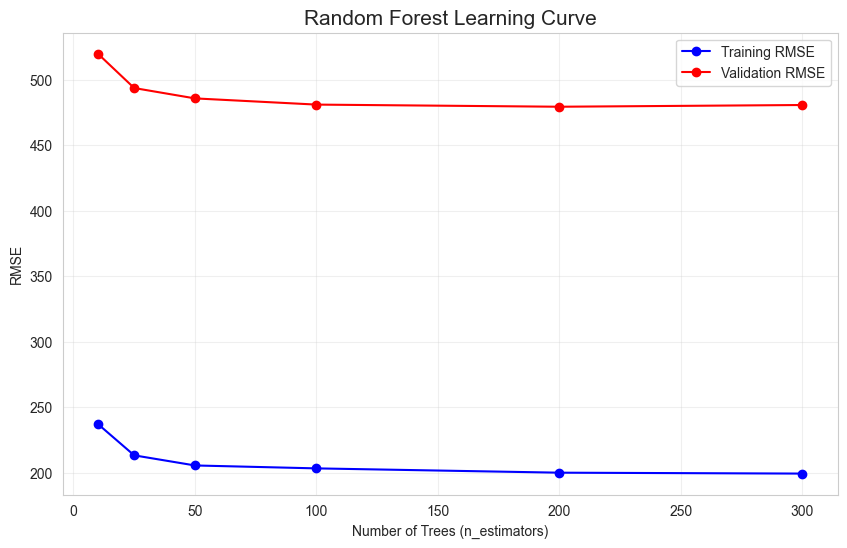


Initial Model Test RMSE (with 300 trees): 495.06


In [5]:
# --- INITIAL MODEL & LEARNING CURVE GENERATION ---

# Define the range of trees to evaluate for the learning curve
n_trees_steps = [10, 25, 50, 100, 200, 300]

train_scores = []
val_scores = []

# We use warm_start=True to incrementally add trees without retraining from scratch
model_init = RandomForestRegressor(
    n_estimators=10, # Start small
    warm_start=True, 
    random_state=42, 
    n_jobs=-1
)

print("Generating Learning Curve (RMSE vs n_estimators)...")
for n_trees in n_trees_steps:
    model_init.n_estimators = n_trees
    model_init.fit(X_train, y_train)
    
    # Predict and Calculate RMSE
    train_pred = model_init.predict(X_train)
    val_pred = model_init.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    train_scores.append(train_rmse)
    val_scores.append(val_rmse)
    print(f"Trees: {n_trees} | Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")

# --- PLOT LEARNING CURVE ---
plt.figure(figsize=(10, 6))
plt.plot(n_trees_steps, train_scores, label='Training RMSE', color='blue', marker='o')
plt.plot(n_trees_steps, val_scores, label='Validation RMSE', color='red', marker='o')

plt.title('Random Forest Learning Curve', fontsize=15)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate on TEST Set using the final state of the model (300 trees)
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"\nInitial Model Test RMSE (with {n_trees_steps[-1]} trees): {rmse_init_test:.2f}")

### 5. Optuna Hyperparameter Optimization
We optimize hyperparameters (Depth, Split criteria, Features per tree) to minimize RMSE on the Validation set.

In [6]:
# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0), # Fraction of features
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    
    # Train on Training set
    model.fit(X_train, y_train)
    
    # Evaluate on Validation set
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    
    return rmse

# --- RUN OPTIMIZATION ---
# We reduce n_trials slightly as RF can be slower to train than LGBM
study = optuna.create_study(direction='minimize', study_name='Rice_Yield_RF')
study.optimize(objective, n_trials=20) 

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-26 20:44:44,764] A new study created in memory with name: Rice_Yield_RF
[I 2025-11-26 20:44:53,166] Trial 0 finished with value: 473.2040884320558 and parameters: {'n_estimators': 482, 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.7168337004356361}. Best is trial 0 with value: 473.2040884320558.
[I 2025-11-26 20:44:56,636] Trial 1 finished with value: 472.60330575646947 and parameters: {'n_estimators': 158, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.5705405271371091}. Best is trial 1 with value: 472.60330575646947.
[I 2025-11-26 20:44:57,844] Trial 2 finished with value: 527.5077705617991 and parameters: {'n_estimators': 264, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.14269061662526125}. Best is trial 1 with value: 472.60330575646947.
[I 2025-11-26 20:45:02,011] Trial 3 finished with value: 472.55711762678413 and parameters: {'n_estimators': 196, 'max_depth': 


Best Parameters found:
{'n_estimators': 219, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.4565305361563947}


### 6. Optuna Visualization
Visualizing the tuning process to understand parameter importance and convergence.

In [7]:
# --- OPTUNA VISUALIZATIONS ---
name = "Rice_Yield_Model_RF"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Tuned Model Training
Retraining the model using the best parameters found on the full history (Train + Validation).

In [8]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 2. Initialize with Best Params
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = RandomForestRegressor(**best_params)

# 3. Train on Full History
print("Training final Random Forest model on full history...")
final_model.fit(X_train_full, y_train_full)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

Training final Random Forest model on full history...


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=527.17, R2=0.9436
Initial Model:  RMSE=495.06, R2=0.9502
Tuned Model:    RMSE=473.50, R2=0.9545 (RMSE Improved 10.18%)


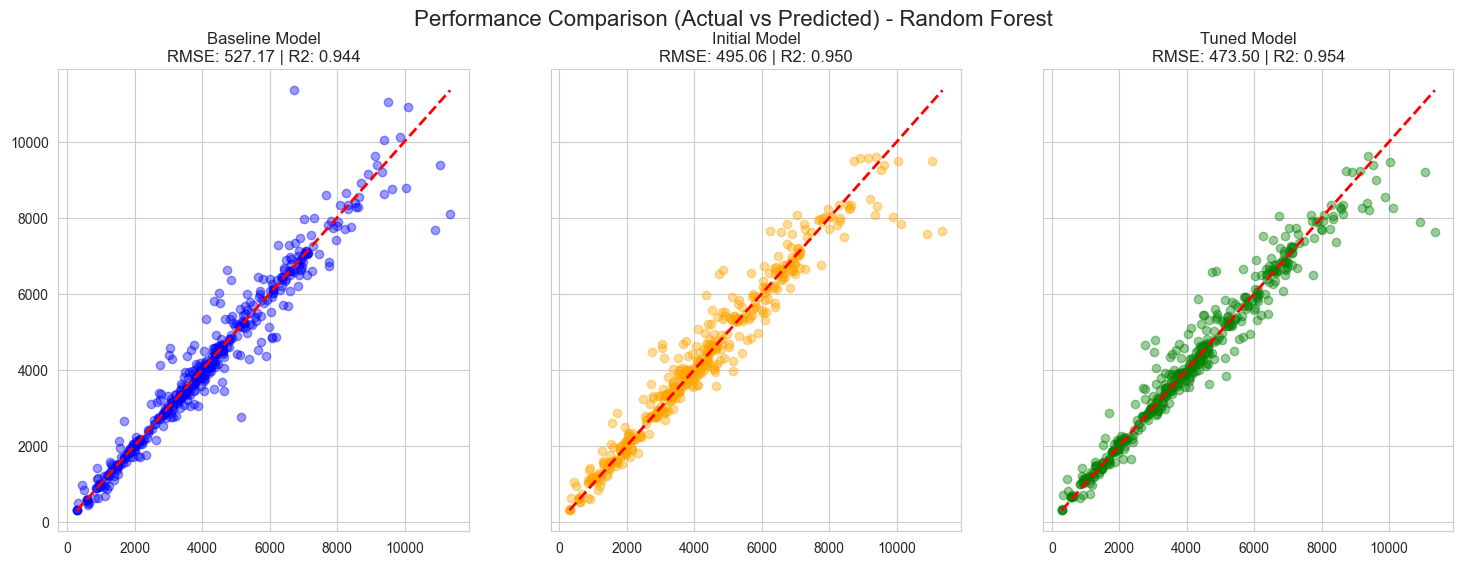

In [9]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle('Performance Comparison (Actual vs Predicted) - Random Forest', fontsize=16)
plt.show()


--- Top 20 Most Important Features (Text Report) ---
                                    Feature  Importance
0                         avg_yield_rice_1y    0.438687
1                         avg_yield_rice_3y    0.329763
2                         avg_yield_rice_6y    0.121892
3                     avg_yield_tomatoes_3y    0.023288
4                     avg_yield_tomatoes_6y    0.016786
5                     avg_yield_tomatoes_1y    0.013405
6                   avg_yield_maize_corn_3y    0.007457
7                  avg_yield_watermelons_3y    0.004214
8                  avg_yield_watermelons_6y    0.003747
9                          avg_solar_Annual    0.002670
10                  avg_yield_maize_corn_1y    0.002612
11                 avg_yield_watermelons_1y    0.002567
12  avg_yield_other_vegetables_fresh_nec_3y    0.001588
13                         avg_solar_Autumn    0.001535
14                         avg_solar_Winter    0.001193
15  avg_yield_other_vegetables_fresh_nec_6y    0.0

/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_10508/552143922.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




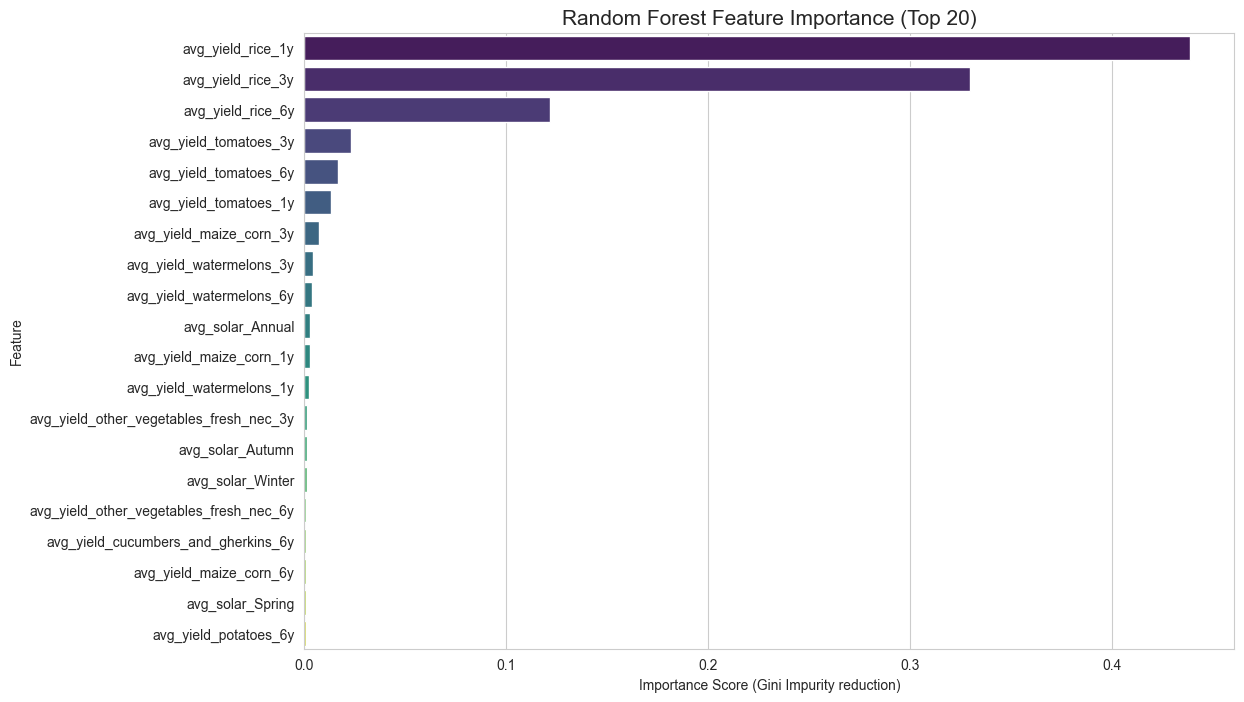

In [10]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances
importances = final_model.feature_importances_
feature_names = X_train.columns

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH using Seaborn/Matplotlib
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title('Random Forest Feature Importance (Top 20)', fontsize=15)
plt.xlabel('Importance Score (Gini Impurity reduction)')
plt.ylabel('Feature')
plt.show()